I've just finished my analysis on the Tasty Bytes' popular recipes project and here's the report.  

# Data Validation  

The original dataset consists of 947 rows and 8 columns, some with missing values or inconsistencies compared to what they were supposed to contain according to the data info they provided to us. Validation column by column:  
  
* **recipe:** same as description, no missing values detected.  
* **calories:** same as description, 52 missing values were detected and each was replaced with the median of calories of the respective "category" grouping.  
* **carbohydrate:** same as description, 52 missing values were detected and each was replaced with the median of carbohydrate of the respective "category" grouping.  
* **sugar:** same as description, 52 missing values were detected and each was replaced with the median of sugar of the respective "category" grouping.  
* **protein:** same as description, 52 missing values were detected and each was replaced with the median of protein of the respective "category" grouping.  
* **category:** no missing values detected, but there was an extra "Chicken Breast" grouping that I decided to remap to the "Chicken" category so as to comply with the given description. So now there are 10 groupings in the "category" column as in the description.
* **servings:** same as description (but I had to turn it into numeric because it was initially character, as it contained a few words), no missing values detected.  
* **high_traffic:** same as description, 373 missing values corresponding to the recipes that didn't trigger high traffic were detected and replaced with "No".
  
After the validation the data still contains 947 rows and 8 columns.

**Validation process**  
First I imported the needed libraries and the dataset and I took a look at the first few rows of the dataset along with its column data types and non-null counts.

In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

# import original data, take a look of the dataframe and check column data types and non-null counts.
df = pd.read_csv(r'C:\Users\nikos\Documents\Nikos\Data Science\Projects\DatacampCertificateProject\recipe_site_traffic_2212.csv')
display(df.head())
df.info()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


* **recipe column:** non-null, numeric as described. I validated its values are unique.

In [2]:
# Checking recipe values are unique
df['recipe'].nunique()

947

* **calories, carbohydrate, sugar, protein columns:** numeric as described, contained 52 missing values each out of 947 (>5%). Validated value range and imputed missing values.

In [3]:
# validation of calories, carbohydrate, sugar and protein value range
df.describe()

,recipe,calories,carbohydrate,sugar,protein
count,947.000000,895.000000,895.000000,895.000000,895.000000
mean,474.000000,435.939196,35.069676,9.046547,24.149296
std,273.519652,453.020997,43.949032,14.679176,36.369739
min,1.000000,0.140000,0.030000,0.010000,0.000000
25%,237.500000,110.430000,8.375000,1.690000,3.195000
50%,474.000000,288.550000,21.480000,4.550000,10.800000
75%,710.500000,597.650000,44.965000,9.800000,30.200000
max,947.000000,3633.160000,530.420000,148.750000,363.360000


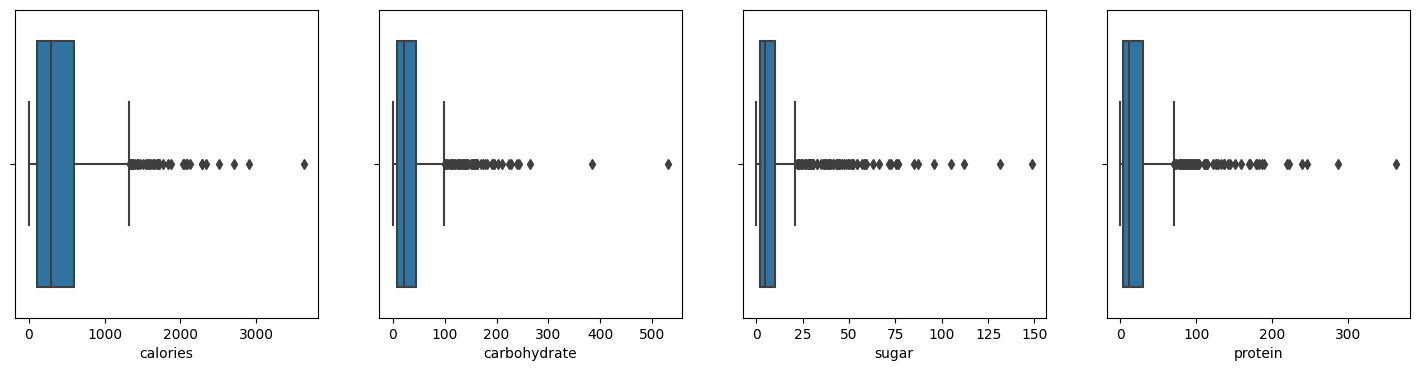

In [4]:
# visualization of unexpectedly high max values
fig, axes = plt.subplots(1, 4, figsize=(18,4))
for i, col in enumerate(['calories','carbohydrate', 'sugar', 'protein']):
    sns.boxplot(x=df[col], ax=axes[i])
    plt.xlabel(col)
plt.show()

**Fig. 1**  
Due to consistency of outliers I didn't touch them, but I filled missing values with the median (not the mean) of their corresponding "category", assuming association between "category" and nutrition characteristics.

In [5]:
# calculate the median of nutrition columns
nutr_medians_by_groupings = df.groupby('category')[['calories', 'carbohydrate', 'sugar', 'protein']].median()

# fill missing values with the median of the corresponding 'category' grouping and check job is done
for col in ['calories', 'carbohydrate', 'sugar', 'protein']:
    df[col] = df[col].fillna(df['category'].map(nutr_medians_by_groupings[col]))
display(df.head())
df.info()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,399.26,19.56,5.23,29.82,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      947 non-null    float64
 2   carbohydrate  947 non-null    float64
 3   sugar         947 non-null    float64
 4   protein       947 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


* **category column:** non-null, character as described. Had to check if it contained 10 categories matching the labels given.

In [6]:
print("There are", len(df['category'].value_counts()), "groupings in the 'category' column")
print(df['category'].value_counts())

There are 11 groupings in the 'category' column
Breakfast         106
Chicken Breast     98
Beverages          92
Lunch/Snacks       89
Potato             88
Pork               84
Vegetable          83
Dessert            83
Meat               79
Chicken            74
One Dish Meal      71
Name: category, dtype: int64


One additional grouping named "Chicken Breast" detected along with the expected. I remapped it to the "Chicken" grouping (as the most relevant), after I checked their nutrition values and "high_traffic" behavior were some kind of similar.

In [7]:
# checking nutrition values
print(nutr_medians_by_groupings)

                calories  carbohydrate   sugar  protein
category                                               
Beverages        126.455        11.250   8.075    0.410
Breakfast        229.380        28.420   4.830   11.685
Chicken          379.870        18.110   3.170   32.980
Chicken Breast   371.335        13.475   3.645   37.770
Dessert          288.550        38.550  24.650    4.810
Lunch/Snacks     369.505        31.985   2.750   12.965
Meat             460.870        19.115   3.385   28.530
One Dish Meal    419.280        25.430   4.040   28.480
Pork             399.260        19.560   5.230   29.820
Potato           269.460        32.540   2.640    5.900
Vegetable        124.305        13.335   3.700    4.835


Nutrition values of "Chicken" and Chicken Breast" groupings were about the same as suspected and then I examined their "high_traffic" behavior. First I checked if all non-null "high_traffic" values were set to "High" or some values were misspelled.

In [8]:
# checking sum of "High" values = sum of non-null "high_traffic" values = 574
pop_recipes = df[df['high_traffic']=='High']
print(len(pop_recipes))

574


Then I compared the percentage of recipes of the two groupings that triggered high traffic.

In [9]:
# Checking that "Chicken" and "Chicken Breast" groupings of "category" have similar popularity
pop_chicken = pop_recipes[pop_recipes['category'] == 'Chicken']
pop_chicken_breast = pop_recipes[pop_recipes['category'] == 'Chicken Breast']
print("There are", len(pop_chicken), "popular Chicken recipes (percentage =", round(100*len(pop_chicken)/len(df[df['category'] == 'Chicken']), 1), "%)")
print("There are", len(pop_chicken_breast), "popular Chicken Breast recipes (percentage =", round(100*len(pop_chicken_breast)/len(df[df['category'] == 'Chicken Breast']), 1), "%)")

There are 27 popular Chicken recipes (percentage = 36.5 %)
There are 46 popular Chicken Breast recipes (percentage = 46.9 %)


So 27 out of 74 (36.5%) Chicken and 46 out of 98 (46.9%) Chicken Breast recipes resulted in high traffic. Not very close results but both were quite low. That's why  I indeed remapped "Chicken Breast" to "Chicken" category.

In [10]:
# turning "Chicken Breast" category into "Chicken"
df['category'] = df['category'].replace('Chicken Breast', 'Chicken')
print(len(df['category'].unique()))
print(df['category'].unique())

10
['Pork' 'Potato' 'Breakfast' 'Beverages' 'One Dish Meal' 'Chicken'
 'Lunch/Snacks' 'Vegetable' 'Meat' 'Dessert']


* **servings column:** non-null but it was object (not numeric as expected) so I explored its values to see why.

In [11]:
# 'servings' category values
print(df['servings'].value_counts())

4               389
6               197
2               183
1               175
4 as a snack      2
6 as a snack      1
Name: servings, dtype: int64


I assigned '4 as a snack' and '6 as a snack' to '4' and '6' respectively and then converted the column data type to numeric to match the description.

In [12]:
# assign '4 as a snack' and '6 as a snack' to '4' and '6' respectively
df['servings'] = df['servings'].replace({'4 as a snack': '4', '6 as a snack': '6'})
print(df['servings'].value_counts())

4    391
6    198
2    183
1    175
Name: servings, dtype: int64


In [13]:
# convert the column data type to numeric
df['servings'] = df['servings'].astype(int)
print(df.dtypes)

recipe            int64
calories        float64
carbohydrate    float64
sugar           float64
protein         float64
category         object
servings          int32
high_traffic     object
dtype: object


* **high_traffic column:** contained only "High" and null values as in the description but, at this point, I just turned null to "No" to avoid null values.

In [14]:
# fill missing "high_traffic" values with "No"
df['high_traffic'] = df['high_traffic'].fillna('No')
display(df.head())
df.info()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,399.26,19.56,5.23,29.82,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,No
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      947 non-null    float64
 2   carbohydrate  947 non-null    float64
 3   sugar         947 non-null    float64
 4   protein       947 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    int32  
 7   high_traffic  947 non-null    object 
dtypes: float64(4), int32(1), int64(1), object(2)
memory usage: 55.6+ KB


# Exploratory Data Analysis
## Target Variable  
Our goal is to predict if a recipe will trigger high traffic to the website, so **high_traffic** is going to be our target variable. I plotted high_traffic frequencies and their percentage (Fig. 2) and noticed that about 60% of the recipes in the dataset lead to high traffic to the site.

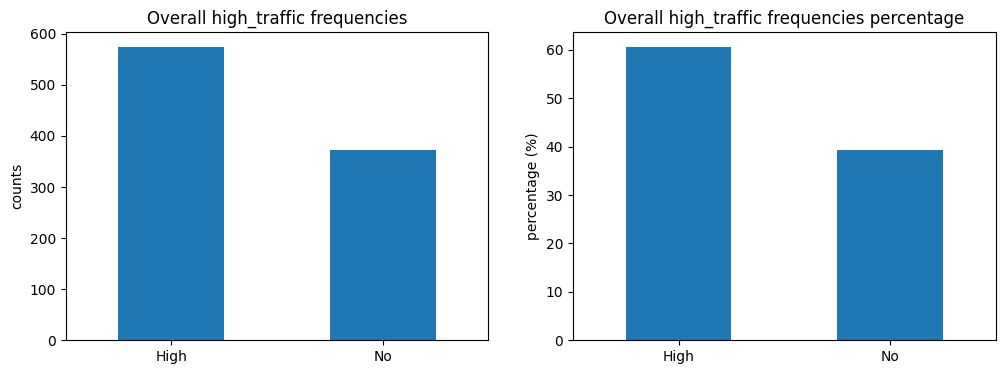

In [15]:
# visualising High and No high_traffic frequencies for the whole dataset
fig, axes = plt.subplots(1, 2, figsize=(12,4))
df["high_traffic"].value_counts().plot.bar(ax=axes[0], rot=0, ylabel="counts", title="Overall high_traffic frequencies")
((df["high_traffic"].value_counts(normalize=True))*100).plot.bar(ax=axes[1], rot=0, ylabel="percentage (%)", title="Overall high_traffic frequencies percentage")
plt.show()

**Fig. 2**
<br>
<br>

## Numeric variables  
The **recipe** column is just an identifier of each recipe in the dataset so **no further analysis** was needed.  
Correlation of **calories, carbohydrate, sugar and protein** had to be examined **(their distributions had already been examined in the validation process**) so I plotted a **correlation heatmap (Fig. 3)** to reveal any linear relationships.   
The **servings** column **was examined in the heatmap too**. However, as the **servings column contains discrete numeric** values, I also **plotted it indipendently (Fig. 4)**.  
It turned out that **no strong or moderate linear relationships between the numeric** variables exist in the dataset.

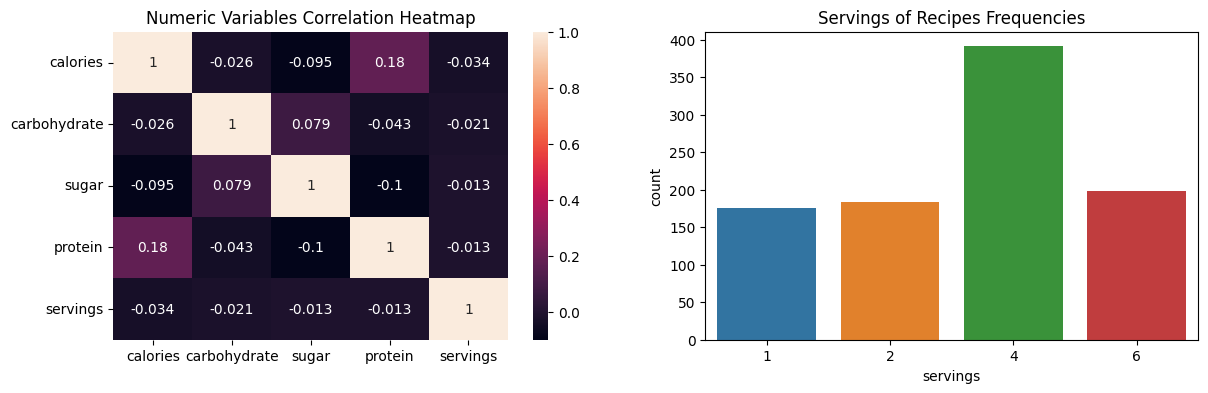

In [16]:
# correlation heatmap of numeric columns and servings countplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
nutr = df[['calories', 'carbohydrate', 'sugar', 'protein', 'servings']]
sns.heatmap(nutr.corr(), annot=True, ax=ax1).set(title='Numeric Variables Correlation Heatmap')
sns.countplot(x=df['servings'],ax=ax2).set(title='Servings of Recipes Frequencies')
plt.show()

**Fig. 3, 4**
<br>
<br>

## Relationships between Numeric Variables and Target Variable high_traffic

To depict any relationships between the **numeric variables and the high_traffic** categorical (binary) variable I created **boxplots (Fig. 5)** that showed **little differences** between the distribution **of High and No** groups of high_traffic for each numerical variable.

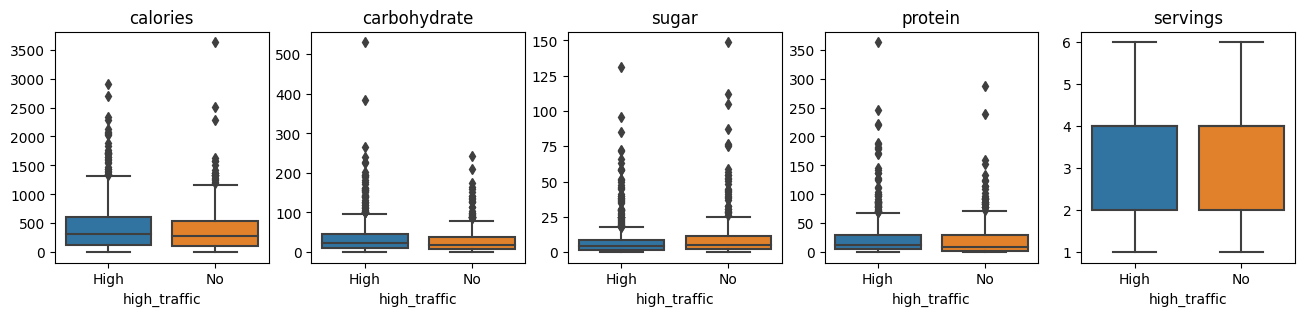

In [17]:
# boxplots of numeric columns by high_traffic categories
fig, axes = plt.subplots(1, 5, figsize=(16,3))
for i, col in enumerate(['calories', 'carbohydrate', 'sugar', 'protein', 'servings']):
    sns.boxplot(x=df['high_traffic'], y=df[col].values, ax=axes[i]).set(title=col)
plt.show()

**Fig. 5**
<br>
<br>

## Categorical Variables

**Apart from the high_traffic**, which is our target variable, there's also the **category** variable.  
I created a horizontal bar plot to visualize the **frequencies of the groupings of the category** column **(Fig. 6)** and noticed that their frequencies were **quite balanced, except for the Chicken** category. That wasn't a surprise, as **combining Chicken Breast with Chicken** category had **resulted in having a larger Chicken** category.

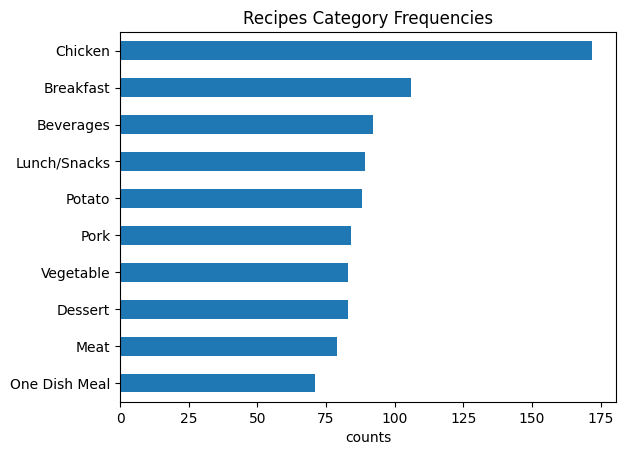

In [18]:
# visualization of "category" column
df['category'].value_counts().plot(kind='barh', xlabel="counts", title="Recipes Category Frequencies").invert_yaxis()

**Fig. 6**
<br>
<br>

## Relationships between Numeric Variables and category Variable

After that I created a visualization of the **distribution of the Numeric Variables by category** groupings **(Fig. 7)** and this time the **nutrition information distributions by category varied a lot** and **justified my earlier choice of median by category for imputing missing values**.

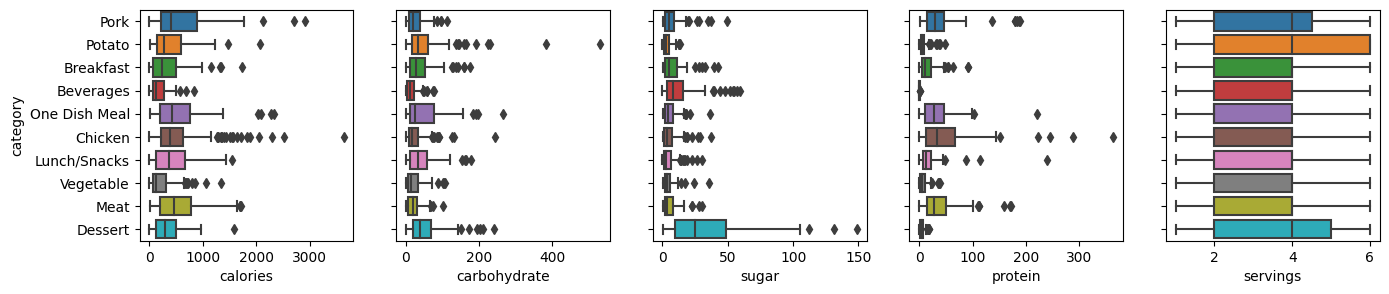

In [19]:
# plot numeric variables by category
fig, axes = plt.subplots(1, 5, figsize=(16,3))   
for i, col in enumerate(['calories', 'carbohydrate', 'sugar', 'protein', 'servings']):
    sns.boxplot(data=df, x=col, y='category', ax=axes[i])
for ax in fig.get_axes():
    ax.label_outer()
plt.show()

**Fig. 7**
<br>
<br>

## Relationship between the Categorical Variable category and the Target Variable high_traffic

Next I **plotted the frequencies of the category groupings that trigger high traffic** to the website (**Fig. 8**), but before doing so, I had to **update pop_recipes to the new groupings** (after turning "Chicken Breast" to Chicken").  
While I could easily tell that **Beverages and Breakfast weren't popular at all**, as they held high frequency places in the Recipes Category Frequencies (Fig. 6) but very low in the Popular Recipes (Fig. 8), it **was not evident which was the most popular category** and which categories performed better than the 80% target we want to achieve.

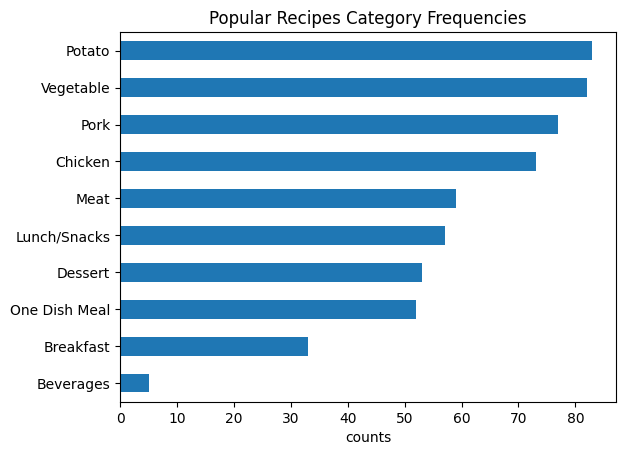

In [20]:
# update pop_recipes with the reduced "category" groupings
pop_recipes_upd = df[df['high_traffic']=='High']

# plot frequencies of the "category" groupings that trigger high traffic
pop_recipes_upd['category'].value_counts().plot(kind='barh', xlabel="counts", title="Popular Recipes Category Frequencies").invert_yaxis()

**Fig. 8**
<br>
<br>

That's why I made a **horizontal bar plot of the percentage of popular recipes by category (Fig. 9)**.

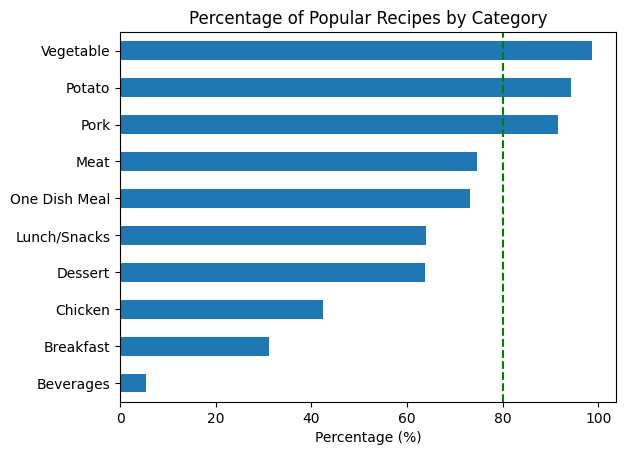

In [21]:
# calculate popular groupings percentage
pop_recipes_upd_ratio = pop_recipes_upd['category'].value_counts()/df['category'].value_counts()
pop_recipes_upd_percent = pop_recipes_upd_ratio * 100
pop_recipes_upd_percent_sorted = pop_recipes_upd_percent.sort_values()

# visualize results
ax = pop_recipes_upd_percent_sorted.plot(kind='barh')
ax.axvline(80,linestyle='--', color='green')
plt.xlabel('Percentage (%)')
plt.title('Percentage of Popular Recipes by Category')
plt.show()

**Fig. 9**
<br>

The first thing that drew my attention was the **really high percentage of Vegetable, Potato and Pork recipes** that **lead to high traffic**. These three categories are performing exceptionally well just by themselves. However, in our goal to maximize the amount of popular recipes I tried to find parameters that work for other categories, too.  
Meat, One Dish Meal groupings which perform near the desired threshold of 80%, as well as Lunch/Snacks, Dessert which perform at around 65% would make a good starting point, so I explored the distribution of their nutrition columns by high_traffic categories to find any trends (**Fig. 10**).  
I found out that **One Dish Meals with large amounts of calories, carbohydrates and proteins tend to be popular** and **Meat recipes with less calories but more carbohydrates and sugar tend to be popular, too**.

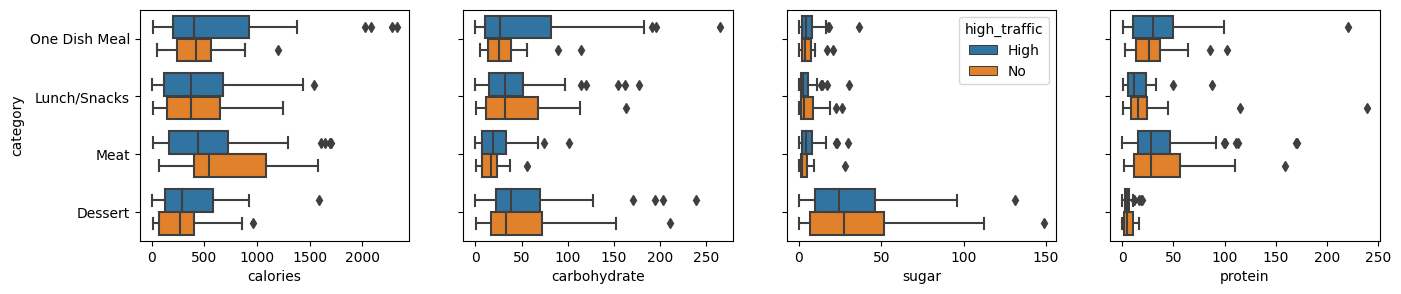

In [22]:
# plot distributions of numerical variables for Meat, One Dish Meal, Lunch/Snacks, Dessert for high_traffic categories
df_subcat = df[df['category'].isin(['Meat', 'One Dish Meal', 'Lunch/Snacks', 'Dessert'])]

fig, axes = plt.subplots(1, 4, figsize=(16,3))   
for i, col in enumerate(['calories', 'carbohydrate', 'sugar', 'protein']):
    sns.boxplot(data=df_subcat, x=col, y='category', hue='high_traffic', ax=axes[i])
for ax in fig.get_axes():
    ax.label_outer()
for ax in axes:
    if ax == axes[2]:
        continue
    else:
        ax.legend([], [], frameon=False)
plt.show()

**Fig. 10**
<br>
<br>

I also had a **quick look at the servings** column. I plotted the frequencies of servings of the popular recipes (**Fig. 11**), I **compared it to the overall frequencies of servings** of the dataframe (**see Fig. 4**) and other than a **slight proportional decrease of the 1 and 2 servings** bars in the chart, nothing special came out.

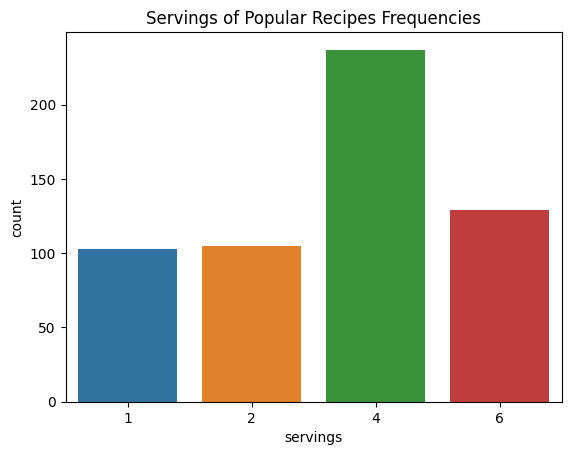

In [23]:
# frequencies of servings in the popular recipes dataframe
sns.countplot(x=pop_recipes_upd['servings'])
plt.title('Servings of Popular Recipes Frequencies')
plt.show()

**Fig. 11**
<br>
<br>

# Model Development and Evaluation

This is a **supervised learning binary classification problem** and I chose a **k-Nearest Neighbors** algorithm as a **baseline model for its simplicity** and a **Logistic Reggression** model as a **comparison** because it's **one of the most common choices for a binary classification problem**.

## Preprocessing Data for Modelling

As our goal is to predict which recipes will lead to high traffic, the **target variable** was the **high_traffic** column which needed to be encoded so as to contain 1 for "High" and 0 for "No" values.  
**Features** were the **rest of the columns without the "recipe"** column (which was just an identifier of each recipe).  
Then I **split the dataset to train and test** sets and deployed a **scaler** on each one.

In [24]:
# encode categorical columns
df_dummies = pd.get_dummies(df, columns=['category', 'high_traffic'], prefix=['cat', 'traffic'])

# drop one 'category' (cat_Beverages) and one 'high_traffic' (traffic_No) dummy as their values are implied by the rest values, as well as the 'recipe' column.
df_dummies.drop(['recipe', 'cat_Beverages', 'traffic_No'], axis=1, inplace=True)

# features and target
X = df_dummies.drop('traffic_High', axis=1).values
y = df_dummies['traffic_High'].values

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

# instantiate a scaler
scaler = StandardScaler()

# fit_transform scaler on the training set, just transform on the test set
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Baseline Model: K-Nearest Neighbors

As a **baseline model**, I instantiated a **GridSearchCV** object of a **KNN** model with a **grid of hyperparameters** to try, in order to improve its performance. Then I printed the **best score** achieved along with its **parameters**.

In [25]:
# knn hyperparameter grid setup
k = np.arange(1,30,2)
param_grid_knn = {'n_neighbors': k, 'weights': ['uniform', 'distance'], 'metric': ['minkowski', 'euclidean', 'manhattan']}

# instantiate a k-neighbors classifier model and a GridSearchCV object
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid=param_grid_knn, cv=5)

# fit the object to the train set
knn_cv.fit(X_train_scaled, y_train)

# print best score and best parameters for knn
print('Best KNN score: {}'.format(knn_cv.best_score_))
print('Best KNN parameters from the grid: {}'.format(knn_cv.best_params_))

Best KNN score: 0.7386990202779676
Best KNN parameters from the grid: {'metric': 'manhattan', 'n_neighbors': 23, 'weights': 'distance'}


On the **train set**, the **best KNN score was 0.74** for n_neighbors=23, weights='distance' and metric='manhattan'.  
Then I used the model to **predict the labels** of the test set and computed the **confusion matrix, classification report and roc auc score**.

In [26]:
# predict the labels of the test set with knn_cv
y_pred_knn = knn_cv.predict(X_test_scaled)

# compute and print the confusion matrix and the classification report for knn
print('Confusion matrix for KNN model:\n{}'.format(confusion_matrix(y_test, y_pred_knn)))
print('Classification Report for KNN model:\n{}'.format(classification_report(y_test, y_pred_knn)))

# predict probabilities and compute and print roc_auc_score
y_pred_probs_knn = knn_cv.predict_proba(X_test_scaled)[:, 1]
print('Roc Auc Score for KNN model: {}'.format(roc_auc_score(y_test, y_pred_probs_knn)))

Confusion matrix for KNN model:
[[ 75  37]
 [ 24 149]]
Classification Report for KNN model:
              precision    recall  f1-score   support

           0       0.76      0.67      0.71       112
           1       0.80      0.86      0.83       173

    accuracy                           0.79       285
   macro avg       0.78      0.77      0.77       285
weighted avg       0.78      0.79      0.78       285

Roc Auc Score for KNN model: 0.8416855904211396


On the **test set**, my **KNN model's precision** was **0.80** and its **roc_auc_score** was **0.84**.

## Comparison Model - Logistic Regression

As a comparison model, I instantiated a **GridSearchCV** object of a **LogisticRegression** model with its **hyperparameters grid** and printed its **best score** and **parameters**.

In [27]:
# logreg hyperparameter grid setup
c_space = np.logspace(-5, 8, 15)
param_grid_logreg = {'C': c_space, 'solver': ['lbfgs', 'newton-cg']}

# instantiate a logistic regression model and a GridSearchCV object
logreg = LogisticRegression(random_state=1)
logreg_cv = GridSearchCV(logreg, param_grid=param_grid_logreg, cv=5)

# fit the object to the train set
logreg_cv.fit(X_train_scaled, y_train)

# print best score and best parameters for logistic regression
print('Best LogisticRegression score: {}'.format(logreg_cv.best_score_))
print('Best LogisticRegression parameters from the grid: {}'.format(logreg_cv.best_params_))

Best LogisticRegression score: 0.7387331966279336
Best LogisticRegression parameters from the grid: {'C': 3.727593720314938, 'solver': 'lbfgs'}


On the **train set**, the **best Logistic Regression score was 0.74** for C=3.73 and solver='lbfgs'.  
Then I used the model to **predict the labels** of the test set and computed the **confusion matrix, classification report and roc auc score**.

In [28]:
# predict the labels of the test set with logreg_cv
y_pred_logreg = logreg_cv.predict(X_test_scaled)

# compute and print the confusion matrix and the classification report for logistic regression
print('Confusion matrix for Logistic Regression model:\n{}'.format(confusion_matrix(y_test, y_pred_logreg)))
print('Classification Report for Logistic Regression model:\n{}'.format(classification_report(y_test, y_pred_logreg)))

# predict probabilities and compute and print roc_auc_score
y_pred_probs_logreg = logreg_cv.predict_proba(X_test_scaled)[:, 1]
print('Roc Auc Score for Logistic Regression model: {}'.format(roc_auc_score(y_test, y_pred_probs_logreg)))

Confusion matrix for Logistic Regression model:
[[ 84  28]
 [ 26 147]]
Classification Report for Logistic Regression model:
              precision    recall  f1-score   support

           0       0.76      0.75      0.76       112
           1       0.84      0.85      0.84       173

    accuracy                           0.81       285
   macro avg       0.80      0.80      0.80       285
weighted avg       0.81      0.81      0.81       285

Roc Auc Score for Logistic Regression model: 0.8686519405450042


On the **test set**, my **Logistic Regression model's precision** was **0.84** and its **roc_auc_score** was **0.87**.

## Results - Comparison of the two Models

KNN Classifier and Logistic Regression achieved almost identical scores during training (about 0.74), but on the unseen labels of the test set, the results of the **Logistic Regression in all but one** (Recall where it performed 0.01 lower than KNN) **metrics of the classification report**, as well as the **roc_auc_score**, **outperformed or equally performed with the KNN Classifier**.  
The reason I calculated the **roc_auc_score** of each model was that it gave me an **overall idea** of how well they could **predict** which recipes will lead to **high traffic**, which was the **first of our two goals** set.
To compare the performance of the models towards the **main goal** of **correctly predicting high traffic** recipes over 80% I chose **Precision** as the **appropriate metric**, as it depicts the TP/(TP+FP) ratio.  
**Logistic Regression's roc_auc_score (0.87)** shows that it can generally label unseen data **better than KNN (0.84)**.   
**Logistic Regression's Precision (0.84) was better than KNN's (0.80)** too, which means **Logistic Regression can correctly predict high traffic at a higher rate**. These findings are depicted below **(Fig. 12)**.
**Logistic Regression** model is the **suggested model for this project**.

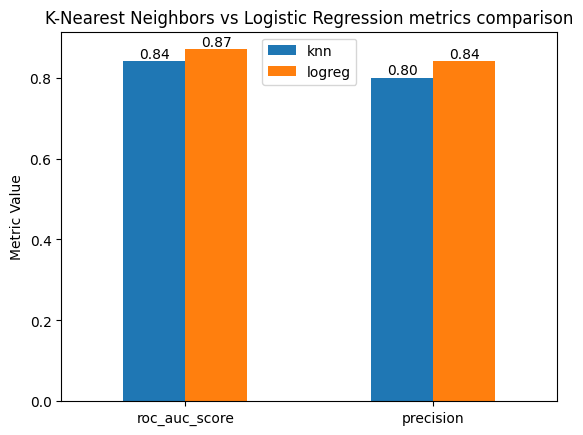

In [29]:
# put the results into a dataframe - results
results = pd.DataFrame({'knn': [0.84, 0.80], 'logreg': [0.87, 0.84]}, index=['roc_auc_score', 'precision'])

# plot results
ax = results.plot.bar()
plt.legend(loc='upper center')
ax.tick_params(rotation=0)
ax.set(ylabel='Metric Value', title='K-Nearest Neighbors vs Logistic Regression metrics comparison')
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')

**Fig. 12**

# Business Scope Oriented Analysis of the Results

The **goals of the project** that was assigned to us, were to **predict which recipes lead to high traffic** and to **correctly predict high traffic recipes 80%** of the time.  
While performing EDA, I found out that displaying the **Product Manager's favorite recipes** on their homepage, led in **high traffic 60%** of the times (see **Fig. 2**).  I also found out that the category of a recipe is the key variable associated with high traffic. Specificaly, **Vegetable, Potato and Pork led to high traffic in a very high rate, over 90% (see Fig. 9)** and should be **the most frequent categories of recipes exhibited** on the homepage. However, as variety should exist to retain customers' interest, I would **propose the frequencies of the categories** of the recipes displayed on the homepage, **to match the order and proportion they hold in the Percentage of Popular Recipes** by Category graph (Fig. 9) to try **going along with the current trend in the market** as depicted below (**Fig. 13**).

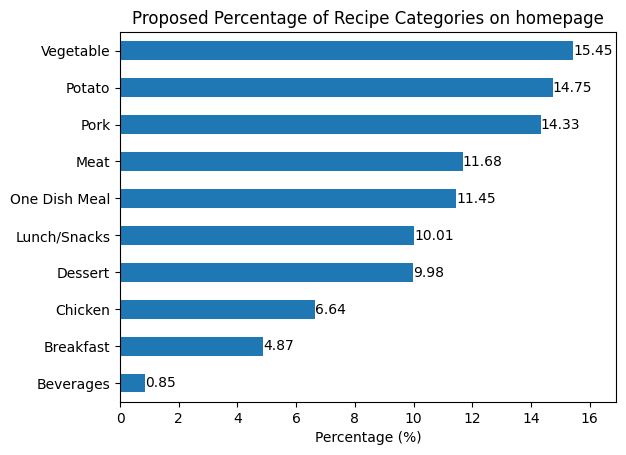

In [30]:
# calculate proposed percentage
prop_cat_displ = pop_recipes_upd_percent_sorted/pop_recipes_upd_percent_sorted.sum()
percent_cat_displ = prop_cat_displ * 100

# plot proposed percentage
ax = percent_cat_displ.plot(kind='barh')
plt.xlabel('Percentage (%)')
plt.title('Proposed Percentage of Recipe Categories on homepage')
ax.bar_label(ax.containers[0], fmt='%.2f')
ax.set_xlim(0, 16.9)
plt.show()

**Fig. 13**
<br>
<br>

# Definition of a KPI for the Business to monitor

The business should monitor the **percentage of recipes that lead to high traffic** when displayed on their homepage, **as KPI**. Based on the data they provided us, its **current value** is about **60%** (**see Fig. 2**) and we are expected to help them **increase it to 80%**.

# Conclusion - Recommendations

As we saw earlier (**see Fig. 12**), **Logistic Regression's roc_auc_score and Precision were 0,87 and 0.84**, against the **inferior 0.84 and 0.80 for the K-Nearest Neighbors** model, so **we should deploy the Logistic Regression model to achieve our goals**. Its Precision of 0.84, means that **it can correctly predict high traffic recipes 84%** of time which **surpasses the 80% goal** set.  
I recommend the business display the **proposed proportions of recipes categories (see Fig. 13)**, but to **keep track of the trends** as with the model deployment, popular recipes from all categories will appear more often and may attract **many new customers**, which might **change the current trend**.  
Also, for the categories with **low popularity** (Beverages, Breakfast, Chicken) I suggest they **create many subgroups - not visible** to the customers (or visible as tags), just **for better analysis** - for each one (for example the Breakfast category could have different features for every element it includes as eggs, bacon, milk, tea, juice, fruit etc) so that it would be easier to identify which of them increase the chances to be popular, as it seems that the **category of the recipe is the deciding factor for being popular** or not.  
Moreover, **Time to make** and **Cost per serving** are data that exist, since they appear on the website and **should be added to the data collected to be examined** along with the others in order to **improve the performance** of the model.  
Finally, **date data should be gathered** for every recipe displayed, as **seasonal or even date specific trends** should probably exist.